# The Data

The work performed herein was built off of the shoulders of giants, the original project that created the dataset and labeled the images. Here follows an excerpt from their site describing the data.

> [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.4002935.svg)](https://doi.org/10.5281/zenodo.4002935)
>__Project member(s)__:\
>Topher Allen; Zach Anderson; Berlin Chen; Ameya Daigavane; Annie Didier; Marko Green; Paul Horton; Hannah Kerner; Lauren Klein; Benjamin Kolber; Ellie Kuang; Kyle Kung; Jake Lee; Justin Martia; Brian Milch; James Montgomery; Kyle Pearson; Sanjna Ravichandar; Arun Viswanathan; Caleb Wagner; Amruta Yelamanchili; Brandon Zhao
>
>__Abstract__:\
>This dataset contains a total of 64,947 landmark images that were detected and extracted from HiRISE browse images, spanning 232 separate source images.
>
>This set was formed from 10,815 original landmarks. Each original landmark was cropped to a square bounding box that included the full extent of the landmark plus a 30-pixel margin to the left, right, top, and bottom. Each landmark was then resized to 227x227 pixels. 9,022 of these images were then augmented to generate 6 additional landmarks using the following methods:
>
>90 degrees clockwise rotation
>180 degrees clockwise rotation
>270 degrees clockwise rotation
>Horizontal flip
>Vertical flip
>Random brightness adjustment
>The remaining 1,793 images were not augmented. Combining these with the 7*9,022 images, gives a total of 64,947 separate images.
>
> __Contents__:
>- map-proj-v3_2/: Directory containing individual cropped landmark images
>- labels-map-proj-v3_2.txt: Class labels (ids) for each landmark image. File includes two columns separated by a space: filename, class_id
>- labels-map-proj-v3_2_train_val_test.txt: Includes train/test/val labels and upsampling used for trained model. File includes three columns separated by a space: filename, class_id, set
>- landmarks_map-proj-v3_2_classmap.csv: Dictionary that maps class ids to semantic names
>
> __Class Discussion__:\
>We give a discussion of the various landmarks that make up our classes.
>
>Bright dune and dark dune are two sand dune classes found on Mars. Dark dunes are completely defrosted, whereas bright dunes are not. Bright dunes are generally bright due to overlying frost and can exhibit black spots where parts of the dune are defrosting.
>
>The crater class consists of crater images in which the diameter of the crater is greater than or equal to 1/5 the width of the image and the circular rim is visible for at least half the crater's circumference.
>
>The slope streak class consists of images of dark flow-like features on slopes. These features are believed to be formed by a dry process in which overlying (bright) dust slides down a slope and reveals a darker sub-surface.
>
>Impact ejecta refers to material that is blasted out from the impact of a meteorite or the eruption of a volcano. We also include cases in which the impact cleared away overlying dust, exposing the underlying surface. In some cases, the associated crater may be too small to see. Impact ejecta can also include lava that spilled out from the impact (blobby ("lobate") instead of blast-like), more like an eruption (triggered by the impact). Impact ejecta can be isolated, or they can form in clusters when the impactor breaks up into multiple fragments.
>
>Spiders and Swiss cheese are phenomena that occur in the south polar region of Mars. Spiders have a central pit with radial troughs, and they are believed to form as a result of sublimation of carbon dioxide ice. This process can produce mineral deposits on top, which look like dark or light dust that highlights cracks in the CO2 ice. Spiders can resemble impact ejecta due to their radial troughs, but impact ejecta tends to have straight radial jets that fade as they get farther from the center. The spider class also includes fan-like features that form when a geyser erupts through the CO2 layer and the material is blown by the wind away from the cracks. Fans are typically unidirectional (following the wind direction), whereas impact ejecta often extends in multiple directions. Swiss cheese is a terrain type that consists of pits that are formed when the sun heats the ice making it sublimate (change solid to gas).
>
>Other is a catch-all class that contains images that fit none of the defined classes of interest. This class makes up the majority of our data set.


# Business Understanding

Space exploration and understanding has been growing over the last few decades with the spark being lit during the space race during the latter half of the 20th century. After the end of the Apollo space program, man's venture into space has been relegated to low earth orbit missions.  

Unmanned missions have since had many a success story such as the Voyager 2 going interstellar in 2018, over 40 years after its launch. The future of space exploration is going to be handled by such manned missions for the foreseeable future. However, being physically on site isn't the only way to explore space.  

For centuries, man has looked up at the night sky to find out more about our celestial neighbors. With improvements in technologies our ability to gather data through telescopes and cameras has improved significantly and the value provided by telescopes in space has been immeasurable. The James Webb (infrared) telescope was launched in December 2021 and hopes to view objects too old, distant, and faint for the Hubble Space Telescope.

Pointing the telescope and gathering data is only the first step. Being able to parse terabytes, petabytes or even yottabytes of data manually is a nigh impossible task, a task computer vision is especially suited for. Being able to identify interesting features can help us whittle down potential candidates to explore 'in-person' and in the long run help mitigate losses.

Interest in space exploration has seen a resurgence with private enterprise taking an interest. Although this project specifically looks at the Mars topography, similar techniques can be applied to any celestial body, or even to our home planet.

# Overview
We shall be using images captured from the HiRISE camera system on board the Mars Reconnaisance Orbiter which was built under direction from University of Arizona's Lunar and Planetary Laboratory. Following is an excerpt from the [University of Arizona website](https://www.lpl.arizona.edu/missions/hirise-mro).

>The __Hi__gh __R__esolution __I__maging __S__cience __E__xperiment (HiRISE) onboard the Mars Reconnaissance Orbiter, is the most powerful camera ever sent to another planet. The resolution of the camera allows us to see the Red Planet in amazing detail, and lets other missions, like the Mars Science Laboratory, find a safe place to land and carry out amazing science. The operations center, which includes not only observation planning, but the execution of commands sent to the spacecraft along with actual image processing, is located within LPL at the University of Arizona.

We shall be building off of the work performed by the original team. The dataset comes pre-augmented and segmented into training, validation and test sets. The test side will be set aside to ascertain effectiveness of our final model. The training set will be used to train the model and the validation scores on the validation set will be used as a metric to pick our model, specifically our validation loss.

# Imports

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

import tensorflow as tf

seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)
import seaborn as sns

tf_chkpt_path = 'tf_TransferLearning_8Classes'

In [41]:
from src.helperFunctions import display_model_trainTestGraphs

# Training Set

In [43]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=2,
    color_mode='rgb',
    class_mode='categorical'
)

Found 48979 images belonging to 8 classes.


# Validation Set

In [44]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=10,
    color_mode='rgb',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


# Test Set

In [45]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=1,
    color_mode='rgb',
    class_mode='categorical'
)

Found 1793 images belonging to 8 classes.


# Modeling

## Modeling Callbacks
Tensorflow's neural networks employs callbacks which allow for additional features.

The disadvantage of having a high learning rate is the model may not converge and bounce around the optimal solution, while the disadvantage of a small learning rate is the model has to train longer to get to a solution. LearningRateScheduler is a callback that allows us to change the learning rate of the algorithm _during_ the training process. Using such a tool can allow us to get the best of both worlds. 
It can be exact learning rates for sets of epochs if desired, however, we are going to use it to decrease by a percentage for every epoch past epoch 10. 

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch >80:
        return lr
    else:
        return lr * tf.math.exp(-0.01)
    
    
lr_schd_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

ModelCheckpoint as the name suggests allows us to create a checkpoint and save the model. By default, a model will retain the weights of the last epoch, however depending upon your parameters and how long the model was run it may not be the best parameters. I used it to capture model weights for the epoch where validation loss was at its minimum.

In [57]:
best_model = ModelCheckpoint(tf_chkpt_path+'_best_model.hdf5', 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             save_freq='epoch')

We'll also be using a CSVLogger callback to make a dedicated log file that will capture all metrics for every epoch at the end of the epoch for posterity and visualizations

In [55]:
csv_logger = CSVLogger('TransferLearning_VGG16_Logger.log', separator=',', append=False)

# VGG 16

In [58]:
vgg = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    classes=8,
    classifier_activation='softmax',
    input_shape=(227,227,3),
)

In [59]:
model = tf.keras.Sequential([
  vgg,
  layers.Flatten(),
    layers.Dense(8, activation='softmax')
])


model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy',
#                        Precision(),
#                        Recall()
                       ])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 8)                 200712    
                                                                 
Total params: 14,915,400
Trainable params: 14,915,400
Non-trainable params: 0
_________________________________________________________________


In [60]:
results = model.fit(train_generator,
                    steps_per_epoch=75,
                    epochs=450,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1,
                    callbacks=[
                        lr_schd_cb,
                        csv_logger,
                        best_model
                    ]
                    )

Epoch 1/450
75/75 [==============================] - ETA: 0s - loss: 1.0515 - accuracy: 0.7333
Epoch 1: val_loss improved from inf to 0.99399, saving model to tf_TransferLearning_8Classes_best_model.hdf5
75/75 [==============================] - 65s 860ms/step - loss: 1.0515 - accuracy: 0.7333 - val_loss: 0.9940 - val_accuracy: 0.7916 - lr: 1.0000e-05
Epoch 2/450
75/75 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.8133
Epoch 2: val_loss improved from 0.99399 to 0.91045, saving model to tf_TransferLearning_8Classes_best_model.hdf5
75/75 [==============================] - 64s 862ms/step - loss: 0.8054 - accuracy: 0.8133 - val_loss: 0.9105 - val_accuracy: 0.7916 - lr: 1.0000e-05
Epoch 3/450
75/75 [==============================] - ETA: 0s - loss: 0.7936 - accuracy: 0.7933
Epoch 3: val_loss improved from 0.91045 to 0.81344, saving model to tf_TransferLearning_8Classes_best_model.hdf5
75/75 [==============================] - 64s 862ms/step - loss: 0.7936 - accuracy:

75/75 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.9133
Epoch 27: val_loss did not improve from 0.56292
75/75 [==============================] - 65s 880ms/step - loss: 0.3385 - accuracy: 0.9133 - val_loss: 0.5645 - val_accuracy: 0.8351 - lr: 8.4366e-06
Epoch 28/450
75/75 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.8867
Epoch 28: val_loss improved from 0.56292 to 0.56143, saving model to tf_TransferLearning_8Classes_best_model.hdf5
75/75 [==============================] - 66s 885ms/step - loss: 0.3248 - accuracy: 0.8867 - val_loss: 0.5614 - val_accuracy: 0.8325 - lr: 8.3527e-06
Epoch 29/450
75/75 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.8200
Epoch 29: val_loss did not improve from 0.56143
75/75 [==============================] - 66s 888ms/step - loss: 0.5128 - accuracy: 0.8200 - val_loss: 0.8085 - val_accuracy: 0.7397 - lr: 8.2696e-06
Epoch 30/450
75/75 [==============================] - ETA: 0s - loss

Epoch 53/450
74/75 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9459
Epoch 53: val_loss did not improve from 0.48807
75/75 [==============================] - 65s 877ms/step - loss: 0.2326 - accuracy: 0.9467 - val_loss: 0.5164 - val_accuracy: 0.8514 - lr: 6.5051e-06
Epoch 54/450
75/75 [==============================] - ETA: 0s - loss: 0.2568 - accuracy: 0.9333
Epoch 54: val_loss did not improve from 0.48807
75/75 [==============================] - 65s 883ms/step - loss: 0.2568 - accuracy: 0.9333 - val_loss: 0.5157 - val_accuracy: 0.8513 - lr: 6.4404e-06
Epoch 55/450
75/75 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.9067
Epoch 55: val_loss did not improve from 0.48807
75/75 [==============================] - 65s 882ms/step - loss: 0.3654 - accuracy: 0.9067 - val_loss: 0.5364 - val_accuracy: 0.8416 - lr: 6.3763e-06
Epoch 56/450
75/75 [==============================] - ETA: 0s - loss: 0.2396 - accuracy: 0.9133
Epoch 56: val_loss did no

Epoch 108/450
75/75 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9600
Epoch 108: val_loss did not improve from 0.41439
75/75 [==============================] - 63s 852ms/step - loss: 0.1322 - accuracy: 0.9600 - val_loss: 0.4716 - val_accuracy: 0.8731 - lr: 4.9164e-06
Epoch 109/450
75/75 [==============================] - ETA: 0s - loss: 0.2267 - accuracy: 0.9000
Epoch 109: val_loss did not improve from 0.41439
75/75 [==============================] - 63s 851ms/step - loss: 0.2267 - accuracy: 0.9000 - val_loss: 0.4421 - val_accuracy: 0.8753 - lr: 4.9164e-06
Epoch 110/450
75/75 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9467
Epoch 110: val_loss did not improve from 0.41439
75/75 [==============================] - 63s 851ms/step - loss: 0.1731 - accuracy: 0.9467 - val_loss: 0.4429 - val_accuracy: 0.8715 - lr: 4.9164e-06
Epoch 111/450
75/75 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9533
Epoch 111: val_los

Epoch 136/450
75/75 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.9467
Epoch 136: val_loss did not improve from 0.40815
75/75 [==============================] - 63s 847ms/step - loss: 0.1946 - accuracy: 0.9467 - val_loss: 0.4394 - val_accuracy: 0.8779 - lr: 4.9164e-06
Epoch 137/450
75/75 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9533
Epoch 137: val_loss did not improve from 0.40815
75/75 [==============================] - 63s 850ms/step - loss: 0.1531 - accuracy: 0.9533 - val_loss: 0.4476 - val_accuracy: 0.8782 - lr: 4.9164e-06
Epoch 138/450
75/75 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.9200
Epoch 138: val_loss did not improve from 0.40815
75/75 [==============================] - 64s 859ms/step - loss: 0.2416 - accuracy: 0.9200 - val_loss: 0.4429 - val_accuracy: 0.8749 - lr: 4.9164e-06
Epoch 139/450
75/75 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9267
Epoch 139: val_los

Epoch 164/450
75/75 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9800
Epoch 164: val_loss did not improve from 0.39164
75/75 [==============================] - 65s 878ms/step - loss: 0.0704 - accuracy: 0.9800 - val_loss: 0.5817 - val_accuracy: 0.8649 - lr: 4.9164e-06
Epoch 165/450
75/75 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9267
Epoch 165: val_loss did not improve from 0.39164
75/75 [==============================] - 65s 874ms/step - loss: 0.2543 - accuracy: 0.9267 - val_loss: 0.5858 - val_accuracy: 0.8625 - lr: 4.9164e-06
Epoch 166/450
75/75 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.9000
Epoch 166: val_loss did not improve from 0.39164
75/75 [==============================] - 65s 876ms/step - loss: 0.2564 - accuracy: 0.9000 - val_loss: 0.5012 - val_accuracy: 0.8630 - lr: 4.9164e-06
Epoch 167/450
75/75 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9600
Epoch 167: val_los

Epoch 219/450
75/75 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9667
Epoch 219: val_loss did not improve from 0.36280
75/75 [==============================] - 65s 873ms/step - loss: 0.0609 - accuracy: 0.9667 - val_loss: 0.4572 - val_accuracy: 0.8825 - lr: 4.9164e-06
Epoch 220/450
75/75 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9667
Epoch 220: val_loss did not improve from 0.36280
75/75 [==============================] - 65s 874ms/step - loss: 0.0909 - accuracy: 0.9667 - val_loss: 0.5496 - val_accuracy: 0.8648 - lr: 4.9164e-06
Epoch 221/450
75/75 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9467
Epoch 221: val_loss did not improve from 0.36280
75/75 [==============================] - 65s 871ms/step - loss: 0.1518 - accuracy: 0.9467 - val_loss: 0.4337 - val_accuracy: 0.8844 - lr: 4.9164e-06
Epoch 222/450
75/75 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9333
Epoch 222: val_los

Epoch 247/450
75/75 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9733
Epoch 247: val_loss did not improve from 0.36280
75/75 [==============================] - 64s 867ms/step - loss: 0.1195 - accuracy: 0.9733 - val_loss: 0.4060 - val_accuracy: 0.8965 - lr: 4.9164e-06
Epoch 248/450
75/75 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9533
Epoch 248: val_loss did not improve from 0.36280
75/75 [==============================] - 64s 869ms/step - loss: 0.1541 - accuracy: 0.9533 - val_loss: 0.4181 - val_accuracy: 0.8896 - lr: 4.9164e-06
Epoch 249/450
75/75 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 0.9867
Epoch 249: val_loss did not improve from 0.36280
75/75 [==============================] - 64s 867ms/step - loss: 0.0681 - accuracy: 0.9867 - val_loss: 0.4389 - val_accuracy: 0.8878 - lr: 4.9164e-06
Epoch 250/450
75/75 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9667
Epoch 250: val_los

Epoch 275/450
75/75 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9467
Epoch 275: val_loss did not improve from 0.35445
75/75 [==============================] - 64s 867ms/step - loss: 0.1984 - accuracy: 0.9467 - val_loss: 0.3878 - val_accuracy: 0.8909 - lr: 4.9164e-06
Epoch 276/450
75/75 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9533
Epoch 276: val_loss did not improve from 0.35445
75/75 [==============================] - 64s 869ms/step - loss: 0.1170 - accuracy: 0.9533 - val_loss: 0.4260 - val_accuracy: 0.8863 - lr: 4.9164e-06
Epoch 277/450
75/75 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9800
Epoch 277: val_loss did not improve from 0.35445
75/75 [==============================] - 64s 870ms/step - loss: 0.0570 - accuracy: 0.9800 - val_loss: 0.4014 - val_accuracy: 0.8979 - lr: 4.9164e-06
Epoch 278/450
75/75 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9600
Epoch 278: val_los

Epoch 303/450
75/75 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.9667
Epoch 303: val_loss did not improve from 0.35445
75/75 [==============================] - 64s 867ms/step - loss: 0.0806 - accuracy: 0.9667 - val_loss: 0.4460 - val_accuracy: 0.8916 - lr: 4.9164e-06
Epoch 304/450
75/75 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9800
Epoch 304: val_loss did not improve from 0.35445
75/75 [==============================] - 64s 870ms/step - loss: 0.0624 - accuracy: 0.9800 - val_loss: 0.4731 - val_accuracy: 0.8867 - lr: 4.9164e-06
Epoch 305/450
75/75 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9333
Epoch 305: val_loss did not improve from 0.35445
75/75 [==============================] - 64s 869ms/step - loss: 0.1626 - accuracy: 0.9333 - val_loss: 0.4226 - val_accuracy: 0.8913 - lr: 4.9164e-06
Epoch 306/450
75/75 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9667
Epoch 306: val_los

Epoch 331/450
75/75 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9733
Epoch 331: val_loss did not improve from 0.35445
75/75 [==============================] - 64s 865ms/step - loss: 0.0610 - accuracy: 0.9733 - val_loss: 0.4932 - val_accuracy: 0.8848 - lr: 4.9164e-06
Epoch 332/450
75/75 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9667
Epoch 332: val_loss did not improve from 0.35445
75/75 [==============================] - 64s 866ms/step - loss: 0.1458 - accuracy: 0.9667 - val_loss: 0.4050 - val_accuracy: 0.8966 - lr: 4.9164e-06
Epoch 333/450
75/75 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9533
Epoch 333: val_loss did not improve from 0.35445
75/75 [==============================] - 64s 864ms/step - loss: 0.0733 - accuracy: 0.9533 - val_loss: 0.4135 - val_accuracy: 0.9019 - lr: 4.9164e-06
Epoch 334/450
75/75 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9800
Epoch 334: val_los

Epoch 359/450
75/75 [==============================] - ETA: 0s - loss: 0.1117 - accuracy: 0.9600
Epoch 359: val_loss did not improve from 0.35445
75/75 [==============================] - 64s 870ms/step - loss: 0.1117 - accuracy: 0.9600 - val_loss: 0.4639 - val_accuracy: 0.8863 - lr: 4.9164e-06
Epoch 360/450
75/75 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9533
Epoch 360: val_loss did not improve from 0.35445
75/75 [==============================] - 65s 873ms/step - loss: 0.1355 - accuracy: 0.9533 - val_loss: 0.4758 - val_accuracy: 0.8830 - lr: 4.9164e-06
Epoch 361/450
75/75 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9933
Epoch 361: val_loss did not improve from 0.35445
75/75 [==============================] - 64s 871ms/step - loss: 0.0651 - accuracy: 0.9933 - val_loss: 0.4079 - val_accuracy: 0.8943 - lr: 4.9164e-06
Epoch 362/450
75/75 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9867
Epoch 362: val_los

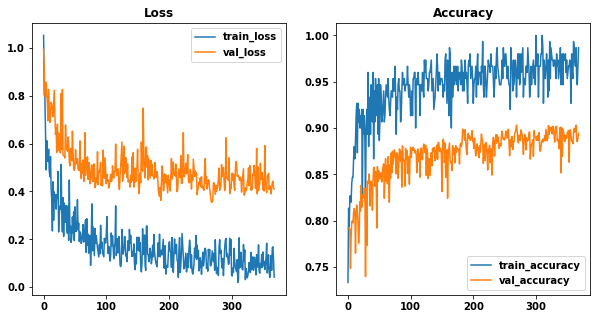

In [61]:
display_model_trainTestGraphs(results)

In [62]:
m = models.load_model('tf_TransferLearning_8Classes_best_model.hdf5')

In [ ]:
m.save('tf_TransferLearning_8class_VGG16.hfpy')

In [63]:
m.evaluate(val_generator)

1418/1418 [==============================] - 62s 44ms/step - loss: 0.3545 - accuracy: 0.8985


[0.35445380210876465, 0.8984832167625427]

In [64]:
m.evaluate(test_generator)

1793/1793 [==============================] - 15s 8ms/step - loss: 0.3714 - accuracy: 0.9202


[0.37138986587524414, 0.9202454090118408]

In [20]:
test_generator.class_indices

{'bright dune': 0,
 'crater': 1,
 'dark dune': 2,
 'impact ejecta': 3,
 'other': 4,
 'slope streak': 5,
 'spider': 6,
 'swiss cheese': 7}

In [18]:
logger_df = pd.read_csv('Logger.log')

In [19]:
logger_df

,epoch,accuracy,loss,lr,precision_1,recall_1,val_accuracy,val_loss,val_precision_1,val_recall_1
0,0,0.546667,1.296185,0.000010,0.808511,0.253333,0.620853,1.218955,0.815843,0.407921
1,1,0.706667,0.928340,0.000010,0.830000,0.553333,0.683819,1.098110,0.862500,0.537238
2,2,0.753333,0.703011,0.000010,0.876106,0.660000,0.647935,1.141763,0.784510,0.504062
3,3,0.820000,0.445320,0.000010,0.922481,0.793333,0.696344,1.067551,0.793866,0.595802
4,4,0.853333,0.528476,0.000010,0.888000,0.740000,0.747461,0.966397,0.852395,0.668585
...,...,...,...,...,...,...,...,...,...,...
118,118,1.000000,0.007853,0.000002,1.000000,1.000000,0.838185,0.929226,0.847475,0.835139
119,119,1.000000,0.003221,0.000002,1.000000,1.000000,0.840217,0.895513,0.851826,0.836831
120,120,1.000000,0.001564,0.000002,1.000000,1.000000,0.840217,0.914230,0.850602,0.836493
121,121,1.000000,0.007329,0.000002,1.000000,1.000000,0.835816,0.969921,0.844757,0.834462
